<a href="https://colab.research.google.com/github/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/Classification_Metrics_2_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">SOLUTION: Classification Metrics 2 (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>


# Instructions


<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2></h2>
<h1>Assignment:</h1>
<p>We will use <a href="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/bank_modified.csv" target="_blank">this dataset</a>. The data, which was modified from <a href="https://archive.ics.uci.edu/ml/datasets/Bank+Marketing" target="_blank">this source</a>, has information about direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. The goal is to predict if the client will subscribe (yes: 1 or no: 0) to a term deposit (the target column is called 'y_yes' in this csv).</p>
<p>Your task is to: </p>
<p>1. Build a DummyClassifier baseline model and a logistic regression model to predict whether or not a client will subscribe. </p>
<p>2. Use GridSearchCV to tune the logistic regression model's hyperparameters to get the best model possible. </p>
<p>3. Then, calculate the following classification metrics for both models:</p>
<p><strong>Metrics to calculate:</strong></p>
<ul>
            <li>Accuracy</li>
            <li>Precision</li>
            <li>Recall</li>
            <li>ROC AUC</li>
            <li>Create a Confusion Matrix</li>
            <li>Additionally, plot the ROC.</li>
        </ul>
<p><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1644005832__Group Discussion.png" style="width: 70px; height: 70px;" width="70" height="70" alt="'''" title="'''"><b>Questions to Think About and Answer:</b></p>
<p>After completing the task, answer the following questions:</p>
<ol>
    <li>Which metric is going to be best to evaluate your classification model for this dataset and why? Hint: think about what each metric means in this specific scenario. What metric is going to help the bank the most?</li>
    <li>Compare your model's accuracy with the baseline model. Do you see any problems here?</li>
    <li>What are other ways you could improve this model?</li>
        </ol>


# Solution

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# import models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# import metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay, )

from sklearn import set_config
set_config(transform_output='pandas')

In [12]:
# load the dataset

df = pd.read_csv('/content/drive/MyDrive/Curriculum/DS 12wk 16 20 PT Curriculum/02: ML/07. Classification and KNN/data/bank_modified.csv')
df.head()

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes
0,30,1787,79,1,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,33,4789,220,1,339,4,0,0,0,0,...,0,1,0,1,0,0,0,1,1,0
2,35,1350,185,1,330,1,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
3,30,1476,199,4,-1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0
4,59,0,226,1,-1,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [13]:
# see distribution of target
df['y_yes'].value_counts(normalize = True)

0    0.88476
1    0.11524
Name: y_yes, dtype: float64

## Preprocessing

In [14]:
# Arrange data into features matrix & target vector
X = df.drop(columns = 'y_yes')
y = df['y_yes']

In [67]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=y)

In [100]:
# # Standardize Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

Let's look at the distribution of our target variable for our testing set. Note: this is our baseline model! If we predicted everything to be in our majority class (in this case, 0), what percent would be get correct?

If we predict everything to be a 0, we would get 88.5% accuracy. That means that we need to get better than 88.5% accuracy to have a decent model.



In [101]:
# baseline
y_test.value_counts(normalize = True)

0    0.885041
1    0.114959
Name: y_yes, dtype: float64

### Define Evaluation Function

In [120]:
def evaluate_model(model_pipe, X_train, y_train, X_test, y_test):
  # Get predictions
  y_pred_train = model_pipe.predict(X_train)
  y_pred_test = model_pipe.predict(X_test)

  # Accuracy
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  print(f'Training accuracy: {train_accuracy:.2f}')
  print(f'Test accuracy: {test_accuracy:.2f}')
  print()

  # Precision
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred_test)

  print(f'Training precision: {train_precision:.2f}')
  print(f'Test precision: {test_precision:.2f}')
  print()


  # Recall
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred_test)

  print(f'Training Recall: {train_recall:.2f}')
  print(f'Test Recall: {test_recall:.2f}')
  print()


  # roc_auc
  y_pred_proba_train = model_pipe.predict_proba(X_train)
  y_pred_proba_test = model_pipe.predict_proba(X_test)
  train_roc_auc = roc_auc_score(y_train, y_pred_proba_train[:,1])
  test_roc_auc = roc_auc_score(y_test, y_pred_proba_test[:,1])

  print(f'Training ROC AUC: {train_roc_auc:.2f}')
  print(f'Test ROC AUC: {test_roc_auc:.2f}')
  print()

  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize='true',
                                          cmap='Greens', ax=axes[0])
  axes[0].set_title("Training Data")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true',
                                          cmap='Reds', ax=axes[1])
  axes[1].set_title("Test Data")

  fig.suptitle("Confusion Matrices")
  fig.tight_layout()
  plt.show()



  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  # Visualize the ROC curve
  RocCurveDisplay.from_estimator(model_pipe, X_train, y_train, ax=axes[0])
  axes[0].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[0].legend();
  axes[0].set_title("Training Data")

  RocCurveDisplay.from_estimator(model_pipe, X_test, y_test, ax=axes[1])
  axes[1].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[1].legend();
  axes[1].set_title("Test Data")

  fig.suptitle('ROC Curves')
  fig.tight_layout()
  plt.show()

### DummyClassifier

In [121]:
# Fit and evaluate dummy classifier
dummy = DummyClassifier()
dummy.fit(X_train_tf, y_train)
evaluate_model(dummy, X_train_tf, y_train, X_test_tf, y_test)

## Logistic Regression

Training accuracy: 0.89
Test accuracy: 0.89

Training precision: 0.60
Test precision: 0.54

Training Recall: 0.21
Test Recall: 0.21

Training ROC AUC: 0.87
Test ROC AUC: 0.84



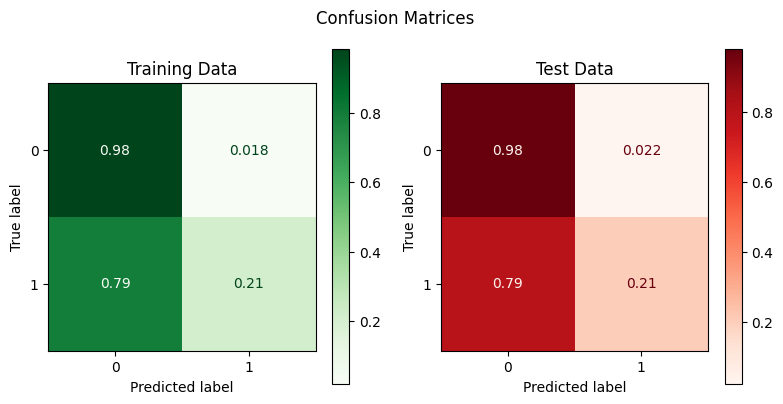

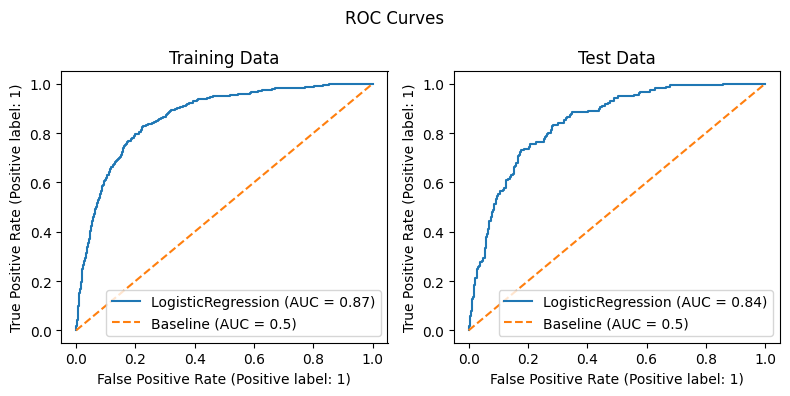

In [123]:
# logistic regression
log_reg = LogisticRegression(solver = 'liblinear')
log_reg.fit(X_train_tf, y_train)
evaluate_model(log_reg, X_train_tf, y_train, X_test_tf, y_test)

## Gridsearch LogReg

In [124]:
# log_reg_pipe.get_params()
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [125]:
# I'm going to use gridsearch to find the best hyperparameters for this model
# Feel free to research this on your own to learn more about this technique
params = {'penalty': ['l1', 'l2'],
          'C': [0.0001, 0.001, 0.01],
          'class_weight': [None, 'balanced']}

In [126]:
# # logistic regression gridsearch

# logistic regression
log_reg = LogisticRegression(solver = 'liblinear')
# grid search to find best hyperparameters
gs = GridSearchCV(log_reg, params, cv = 5)
gs.fit(X_train_tf, y_train)

# here are the best hyperparameters based on the ones I tried
gs.best_params_

{'C': 0.0001, 'class_weight': None, 'penalty': 'l2'}

Training accuracy: 0.89
Test accuracy: 0.88

Training precision: 0.60
Test precision: 0.46

Training Recall: 0.15
Test Recall: 0.15

Training ROC AUC: 0.86
Test ROC AUC: 0.84



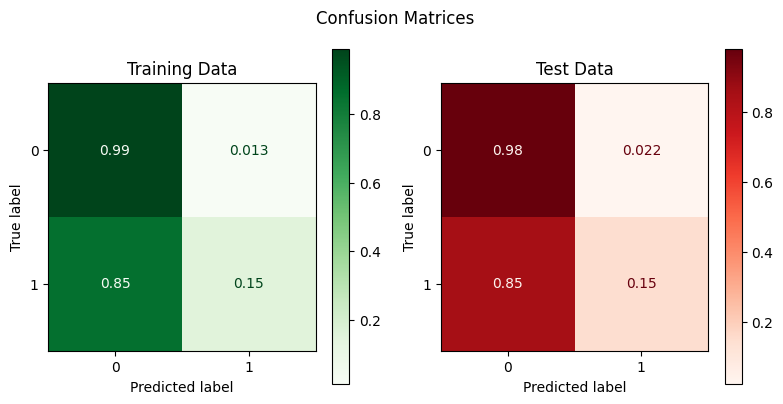

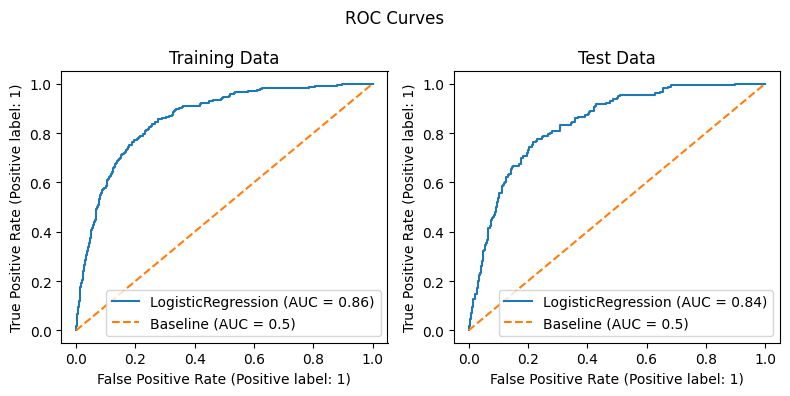

In [127]:
# evaluating the gridsearch's best model
best_log_reg = gs.best_estimator_
evaluate_model(best_log_reg, X_train_tf, y_train, X_test_tf, y_test)

## Answer the following questions

After you have completed the two tasks, answer the following questions.

1. Which metric is going to be best to evaluate your classification models for this dataset and why?
2. Compare your model's accuracy with the baseline model. Do you see any problems here?
3. What are other ways you could improve this model?

**1. Which metric is going to be best to evaluate your classification models for this dataset and why?**



It depends on the bank's goal. Overall, it is probably not the best idea to use accuracy as the evaluation metric for this task. The reason for this is because the data is super imbalanced. If I just predict that every customer will not subscribe, I will get 88.5% of the predictions correct. However, this is not at all helpful to the bank!  

**Recall** describes the percentage of customers that do subscribe that we correctly predicted would subscribe.
A low recall means we could potentially be missing out on customers who actually will subscribe but we predict they will not subscribe.

**Precision** describes the percentage of predictions for the positive class that were correct.

A low precision means we could potentially be wasting marketing materials by marketing to people we predict will subscribe but they actually do not.


Because of this, the metric to optimize for depends on the bank's goal. We probably do not want to overlook customers that will end up subscribing, so optimizing for recall makes sense in this case.

**2. Compare your model's accuracy with the baseline model. Do you see any problems here?**

The dummy classifier's accuracy was 89% (0.89).

The baseline log reg's accuracy was 89% (0.89).

My model's testing accuracy was 88% (0.88).

In [128]:
y_test.value_counts(normalize = True).round(2)

0    0.89
1    0.11
Name: y_yes, dtype: float64

This is not a great model because it is only actually worse than the baseline model!

**3. What are other ways you could improve this model?**

The main problem with this dataset is that it is super imbalanced. There are many techniques for dealing with imbalanced data that I encourage you to research on your own! Some techniques include:
- Optimize for a different metric when fitting the model
- Try a different algorithm
- Over or under sample the dataset to try to balance the target more
- use an algorithm like SMOTE